In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 

from SmithZero import D2torchEngine

In [2]:
torch.manual_seed(42)

### Data Preparation 

In [3]:
from torchvision.datasets import CIFAR10 
import torchvision.transforms as T


# === data transformation === # 
train_T = T.Compose([   T.RandomCrop(32, padding=4),
                        T.RandomHorizontalFlip(), 
                        T.ToTensor(), 
                        T.Normalize(mean= (0.4914, 0.4822, 0.4465),
                                    std=(0.2023, 0.1994, 0.2010)),
                    ])

test_T = T.Compose([T.ToTensor(),
                    T.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                std=(0.2023, 0.1994, 0.2010))
                    ])                  


# === download dataset object === # 
train_data = CIFAR10 (  root="./dataset/train",
                        train=True,
                        download=True,
                        transform=train_T )

test_data = CIFAR10 (   root="./dataset/test",
                        train=False,
                        download=True, 
                        transform=test_T )                    

Files already downloaded and verified
Files already downloaded and verified


### Data Batching 

In [4]:
from torch.utils.data import DataLoader

trainloader = DataLoader(train_data,
                        batch_size=32,
                        shuffle=True, 
                        num_workers=4 )

testloader = DataLoader(test_data,
                        batch_size=32,
                        num_workers=4 )

### Model Design

In [5]:
class LeNet(nn.Module):
    def __init__(self, in_channels=3, n_class=10, p=0.5):
        super(LeNet, self).__init__()
        self.p = p # probability for DropOut layer 
        
        # === Create the convolution layers === # 
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, padding=2)
        self.c3 = nn.Conv2d(6, 16, 5) 
        self.c5 = nn.Conv2d(16, 120, 5) 

        # === Create the linear layers === # 
        self.f6 = nn.Linear(in_features=480, out_features=84)
        self.output = nn.Linear(in_features=84, out_features=n_class)

        # === Create dropout layers === # 
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # === block1 === # 
        x = self.c1(x)
        x = F.relu(x) 
        x = F.max_pool2d(x, kernel_size=2)
        # === block2 === # 
        x = self.c3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # === block3 === # 
        x = self.c5(x)
        x = F.relu(x)
        # ==== flattening === #
        x = nn.Flatten()(x)
        return x 

    def classifier(self, x): 
        # === hidden layler === # 
        if self.p > 0: 
            x = self.drop(x)        
        x = self.f6(x)
        x = F.relu(x)

        # === output layer === # 
        if self.p > 0 :
            x = self.drop(x)
        x = self.output(x)
        return x 
    
    def forward(self, x):
        x = self.featurizer(x) # return (1, 480)
        x = self.classifier(x) # return (1, 10)
        return x 

In [6]:
# check the model 
model = LeNet(in_channels=3, n_class=10, p=0.5)

test_input = torch.randn((1, 3, 32, 32))
test_output = model(test_input)

print(test_output.shape)

torch.Size([1, 10])


### Model Configuration 

In [7]:
model = LeNet(in_channels=3, n_class=10, p=0.5)

loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.SGD( model.parameters(), # (!) be sure to pass in the model.parameters() 
                        lr=1e-3, 
                        momentum=0.9,
                    ) 

In [8]:
#print(model.state_dict())

### Model Training 

In [9]:
AgentDL = D2torchEngine(model, loss_fn, optimizer)  # init. your deep learning engine 

AgentDL.set_loaders(trainloader, testloader)  # init. engine with dataloader 

In [10]:
# check if your model instantiated well 
print(AgentDL.model == model)

True


In [11]:
# Run trianing 
AgentDL.train(n_epochs=50, seed=42)

100%|██████████| 50/50 [09:52<00:00, 11.85s/it]


In [12]:
#print(f"Check your trained weights: {model.state_dict()}") # remember, model == AgentDL.model 
print(AgentDL.total_epochs)

50


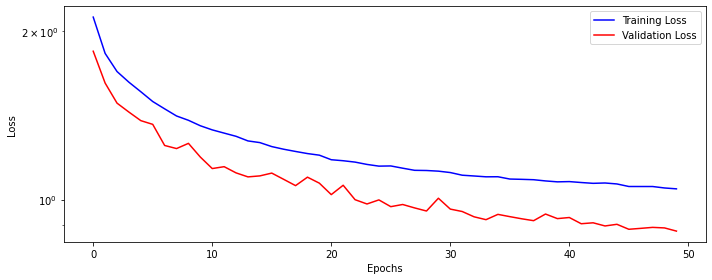

In [13]:
fig = AgentDL.plot_losses()

### Making Predictions 

In [14]:
data, label = test_data[5]

print(type(data))
print(data.size())
print(label)

<class 'torch.Tensor'>
torch.Size([3, 32, 32])
6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


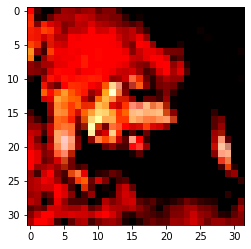

In [15]:
plt.imshow(data.permute(1, 2, 0)) # (C, H, W) -> (H, W, C) for visualization 

In [16]:
data = data.unsqueeze(0)  # (3, 32, 32) -> (1, 3, 32, 32)
predictions = AgentDL.predict(data)

print(type(predictions))
print(predictions.shape)
print(f"label = {np.argmax(predictions, axis=1)}")

<class 'numpy.ndarray'>
(1, 10)
label = [6]


### Save Checkpointing 

In [17]:
AgentDL.save_checkpoint('model_checkpoint.pth')

### Resuming Training 

In [18]:
new_AgentDL = D2torchEngine(model, loss_fn, optimizer)  # init. your deep learning engine 

new_AgentDL.load_checkpoint('model_checkpoint.pth')
#print(new_AgentDL.model.state_dict())

In [19]:
new_AgentDL.set_loaders(trainloader, testloader)
new_AgentDL.train(n_epochs=50, seed=42)

100%|██████████| 50/50 [09:49<00:00, 11.79s/it]


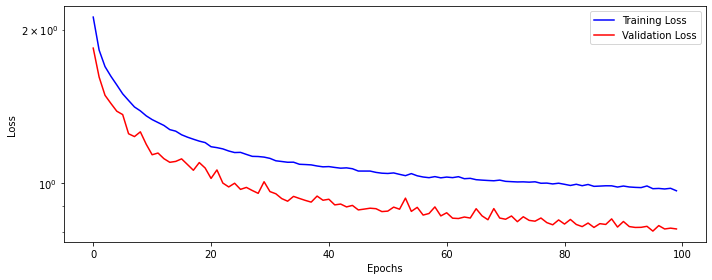

In [20]:
fig = new_AgentDL.plot_losses()